# 🎭 Analyse de l'Inclusion Culturelle à Guérande
Ce notebook analyse les données socio-économiques des quartiers (IRIS) de la commune de Guérande (CODE_COMMUNE = 44069).

L'objectif est de :

- Comprendre la répartition des revenus et de la pauvreté.
- Estimer l'impact financier des tarifs culturels (Athanor, École d'arts) sur les ménages.
- Segmenter les quartiers pour identifier les zones potentiellement prioritaires.
- Proposer des recommandations budgétaires pour une politique culturelle plus inclusive.


In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import warnings

# Ignorer les avertissements pour un affichage plus propre
warnings.filterwarnings('ignore')

# Configuration de l'analyse
CODE_COMMUNE = '44069' # Guérande
TARIFS = {
    'ecole_arts': {'annuel': 350, 'caf': 175},
    'athanor': {'spectacle': 15, 'caf': 7.5, 'nb_annuel': 6}
}


In [48]:
# Définition des Fonctions
def load_and_filter_data(filepath, code_commune):
    """Charge et filtre les données pour une commune spécifique."""
    df = pd.read_csv(filepath, sep=';', encoding='utf-8')
    # Assure que la colonne IRIS est de type string avant d'extraire le code commune
    df['CODE_COMMUNE'] = df['IRIS'].astype(str).str[:5]
    return df[df['CODE_COMMUNE'] == code_commune].copy()

def clean_numeric_columns(df, prefix):
    """Convertit les colonnes spécifiées en type numérique, gérant les virgules."""
    numeric_cols = [col for col in df.columns if col.startswith(prefix)]
    for col in numeric_cols:
        df[col] = pd.to_numeric(df[col].astype(str).str.replace(',', '.'), errors='coerce')
    return df

def analyze_revenus(df):
    """Effectue l'analyse principale : calculs de variables et clustering."""
    # Renommage des variables clés pour plus de clarté
    df['revenu_median'] = df['DISP_MED18']
    df['taux_pauvrete'] = df['DISP_TP6018']
    df['indice_gini'] = df['DISP_GI18']
    
    # Calcul des coûts et de la charge culturelle
    seuil_caf_estime = df['revenu_median'] * 0.6
    cout_annuel = TARIFS['ecole_arts']['annuel'] + (TARIFS['athanor']['spectacle'] * TARIFS['athanor']['nb_annuel'])
    cout_caf = TARIFS['ecole_arts']['caf'] + (TARIFS['athanor']['caf'] * TARIFS['athanor']['nb_annuel'])
    
    df['seuil_caf'] = seuil_caf_estime
    df['cout_sans_caf'] = cout_annuel
    df['cout_avec_caf'] = cout_caf
    # Calcul de la charge en pourcentage du revenu annuel
    df['charge_sans_caf'] = (cout_annuel / (df['revenu_median'] * 12)) * 100
    df['charge_avec_caf'] = (cout_caf / (df['revenu_median'] * 12)) * 100
    
    # Clustering K-Means pour segmenter les IRIS
    scaler = StandardScaler()
    features = scaler.fit_transform(df[['revenu_median', 'taux_pauvrete']])
    # Assurer qu'il y a au moins 2 clusters si possible
    n_clusters = min(2, len(df))
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    df['cluster'] = kmeans.fit_predict(features)
    
    return df

def create_visualizations(df):
    """Crée une figure Matplotlib contenant toutes les visualisations."""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle('🎭 ANALYSE DE L\'INCLUSION CULTURELLE À GUÉRANDE', fontsize=18, fontweight='bold')
    
    # Graphique 1: Revenus médians par IRIS
    ax1 = axes[0, 0]
    df_sorted = df.sort_values('revenu_median')
    colors = ['#ff6b6b' if x < df['revenu_median'].mean() else '#4ecdc4' for x in df_sorted['revenu_median']]
    bars = ax1.bar(df_sorted['IRIS'], df_sorted['revenu_median'], color=colors)
    ax1.axhline(y=df['revenu_median'].mean(), color='black', linestyle='--', alpha=0.7, label=f"Moyenne ({df['revenu_median'].mean():.0f}€)")
    ax1.set_title('Revenus Médians par IRIS', fontsize=12)
    ax1.set_ylabel('Revenu médian (€/mois)')
    ax1.tick_params(axis='x', rotation=90)
    ax1.legend()

    # Graphique 2: Corrélation Revenus vs Taux de Pauvreté
    ax2 = axes[0, 1]
    sns.scatterplot(data=df, x='revenu_median', y='taux_pauvrete', s=120, alpha=0.7, color='#ff6b6b', ax=ax2)
    ax2.set_title('Revenu Médian vs. Taux de Pauvreté', fontsize=12)
    ax2.set_xlabel('Revenu médian (€/mois)')
    ax2.set_ylabel('Taux de pauvreté (%)')

    # Graphique 3: Charge Culturelle sur le Revenu
    ax3 = axes[0, 2]
    df_sorted = df.sort_values('revenu_median')
    x = np.arange(len(df_sorted['IRIS']))
    width = 0.35
    ax3.bar(x - width/2, df_sorted['charge_avec_caf'], width, label='Avec aides CAF', color='#4ecdc4')
    ax3.bar(x + width/2, df_sorted['charge_sans_caf'], width, label='Sans aides CAF', color='#ff6b6b')
    ax3.set_title('Part du Budget Consacrée à la Culture', fontsize=12)
    ax3.set_ylabel('% du revenu annuel')
    ax3.set_xticks(x)
    ax3.set_xticklabels(df_sorted['IRIS'], rotation=90)
    ax3.legend()

    # Graphique 4: Segmentation Socio-Économique (Clusters)
    ax4 = axes[1, 0]
    sns.scatterplot(data=df, x='revenu_median', y='taux_pauvrete', hue='cluster', palette='viridis', s=150, alpha=0.8, ax=ax4)
    ax4.set_title('Segmentation Socio-Économique des IRIS', fontsize=12)
    ax4.set_xlabel('Revenu médian (€/mois)')
    ax4.set_ylabel('Taux de pauvreté (%)')
    ax4.legend(title='Profil')

    # Graphique 5: Distribution des Revenus
    ax5 = axes[1, 1]
    sns.histplot(df['revenu_median'], bins=5, color='#4ecdc4', kde=True, ax=ax5)
    ax5.axvline(df['revenu_median'].mean(), color='red', linestyle='--', label='Moyenne')
    ax5.set_title('Distribution des Revenus Médians', fontsize=12)
    ax5.set_xlabel('Revenu médian (€/mois)')
    ax5.set_ylabel("Nombre d'IRIS")
    ax5.legend()
    
    # Texte de Synthèse
    ax6 = axes[1, 2]
    ax6.axis('off')
    summary_text = f"""
    **SYNTHÈSE CHIFFRÉE**

    • **IRIS analysés :** {len(df)}
    • **Revenu médian moyen :** {df['revenu_median'].mean():.0f} €/an
    • **Taux pauvreté moyen :** {df['taux_pauvrete'].mean():.1f} %
    
    • **Charge culturelle (avec CAF) :** {df['charge_avec_caf'].mean():.2f} %
    • **Charge culturelle (sans CAF) :** {df['charge_sans_caf'].mean():.2f} %
    • **Économie via CAF :** {(df['cout_sans_caf'].mean() - df['cout_avec_caf'].mean()):.0f} €/mois
    """
    ax6.text(0, 0.5, summary_text, fontsize=12, verticalalignment='center', bbox=dict(boxstyle="round,pad=0.5", fc="#f0f0f0", ec="black", lw=1))

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    return fig

In [49]:
# Chargement et Préparation des Données

# Chemin vers le fichier de données.
filepath = 'BASE_TD_FILO_DISP_IRIS_2018.csv'

# Exécution des étapes de chargement et de nettoyage
df = load_and_filter_data(filepath, CODE_COMMUNE)
df = clean_numeric_columns(df, 'DISP_')
df = df.dropna(subset=['DISP_MED18', 'DISP_TP6018'])

print(f"✅ Données chargées et nettoyées pour la commune {CODE_COMMUNE}.")
print(f"Nombre d'IRIS (quartiers) analysés : {len(df)}")

# Afficher les premières lignes du DataFrame pour vérification
df[['IRIS', 'DISP_MED18', 'DISP_TP6018']].head()

✅ Données chargées et nettoyées pour la commune 44069.
Nombre d'IRIS (quartiers) analysés : 5


,IRIS,DISP_MED18,DISP_TP6018
3751,440690101,22180.0,9.7
3753,440690103,21650.0,10.7
3754,440690105,25210.0,10.0
3755,440690106,23990.0,7.7
3756,440690107,23960.0,5.9


In [50]:
# Exécution de l'analyse (calculs des indicateurs et clustering)
df_analyzed = analyze_revenus(df)

# Afficher les nouvelles colonnes calculées pour les premiers IRIS
df_analyzed[['IRIS', 'revenu_median', 'taux_pauvrete', 'charge_sans_caf', 'charge_avec_caf', 'cluster']].head()

,IRIS,revenu_median,taux_pauvrete,charge_sans_caf,charge_avec_caf,cluster
3751,440690101,22180.0,9.7,0.165314,0.082657,1
3753,440690103,21650.0,10.7,0.169361,0.084681,1
3754,440690105,25210.0,10.0,0.145445,0.072722,0
3755,440690106,23990.0,7.7,0.152841,0.076421,0
3756,440690107,23960.0,5.9,0.153033,0.076516,0


In [51]:
# Génération dynamique des chiffres pour la cellule Markdown ci-dessus
print("Analyse des Revenus")
print(f"  - Revenu médian moyen : {df_analyzed['revenu_median'].mean():.0f} €/mois.")
print(f"  - Fourchette des revenus médians : de {df_analyzed['revenu_median'].min():.0f} €/mois à {df_analyzed['revenu_median'].max():.0f} €/mois.")
print(f"  - Taux de pauvreté moyen : {df_analyzed['taux_pauvrete'].mean():.1f} %.\n")

print("Impact des Tarifs Culturels")
cout_sans_caf = df_analyzed['cout_sans_caf'].mean()
cout_avec_caf = df_analyzed['cout_avec_caf'].mean()
print(f"  - Coût annuel pour une famille (sans aides) : {cout_sans_caf:.0f} €.")
print(f"  - Coût annuel pour une famille (avec aides CAF) : {cout_avec_caf:.0f} €.")
print(f"  - Économie potentielle grâce aux tarifs réduits : {cout_sans_caf - cout_avec_caf:.0f} €/an.")

Analyse des Revenus
  - Revenu médian moyen : 23398 €/mois.
  - Fourchette des revenus médians : de 21650 €/mois à 25210 €/mois.
  - Taux de pauvreté moyen : 8.8 %.

Impact des Tarifs Culturels
  - Coût annuel pour une famille (sans aides) : 440 €.
  - Coût annuel pour une famille (avec aides CAF) : 220 €.
  - Économie potentielle grâce aux tarifs réduits : 220 €/an.


# Segmentation Socio-Économique
Le clustering a permis d'identifier 2 profils de quartiers :



In [52]:
# Agréger les résultats par cluster pour les afficher clairement
cluster_summary = df_analyzed.groupby('cluster').agg(
    nombre_iris=('IRIS', 'count'),
    revenu_median_moyen=('revenu_median', 'mean'),
    taux_pauvrete_moyen=('taux_pauvrete', 'mean')
).round(1)

cluster_summary

,nombre_iris,revenu_median_moyen,taux_pauvrete_moyen
cluster,,,
0,3,24386.7,7.9
1,2,21915.0,10.2


✅ Graphiques sauvegardés dans le fichier 'guerande_analysis_dashboard.png'


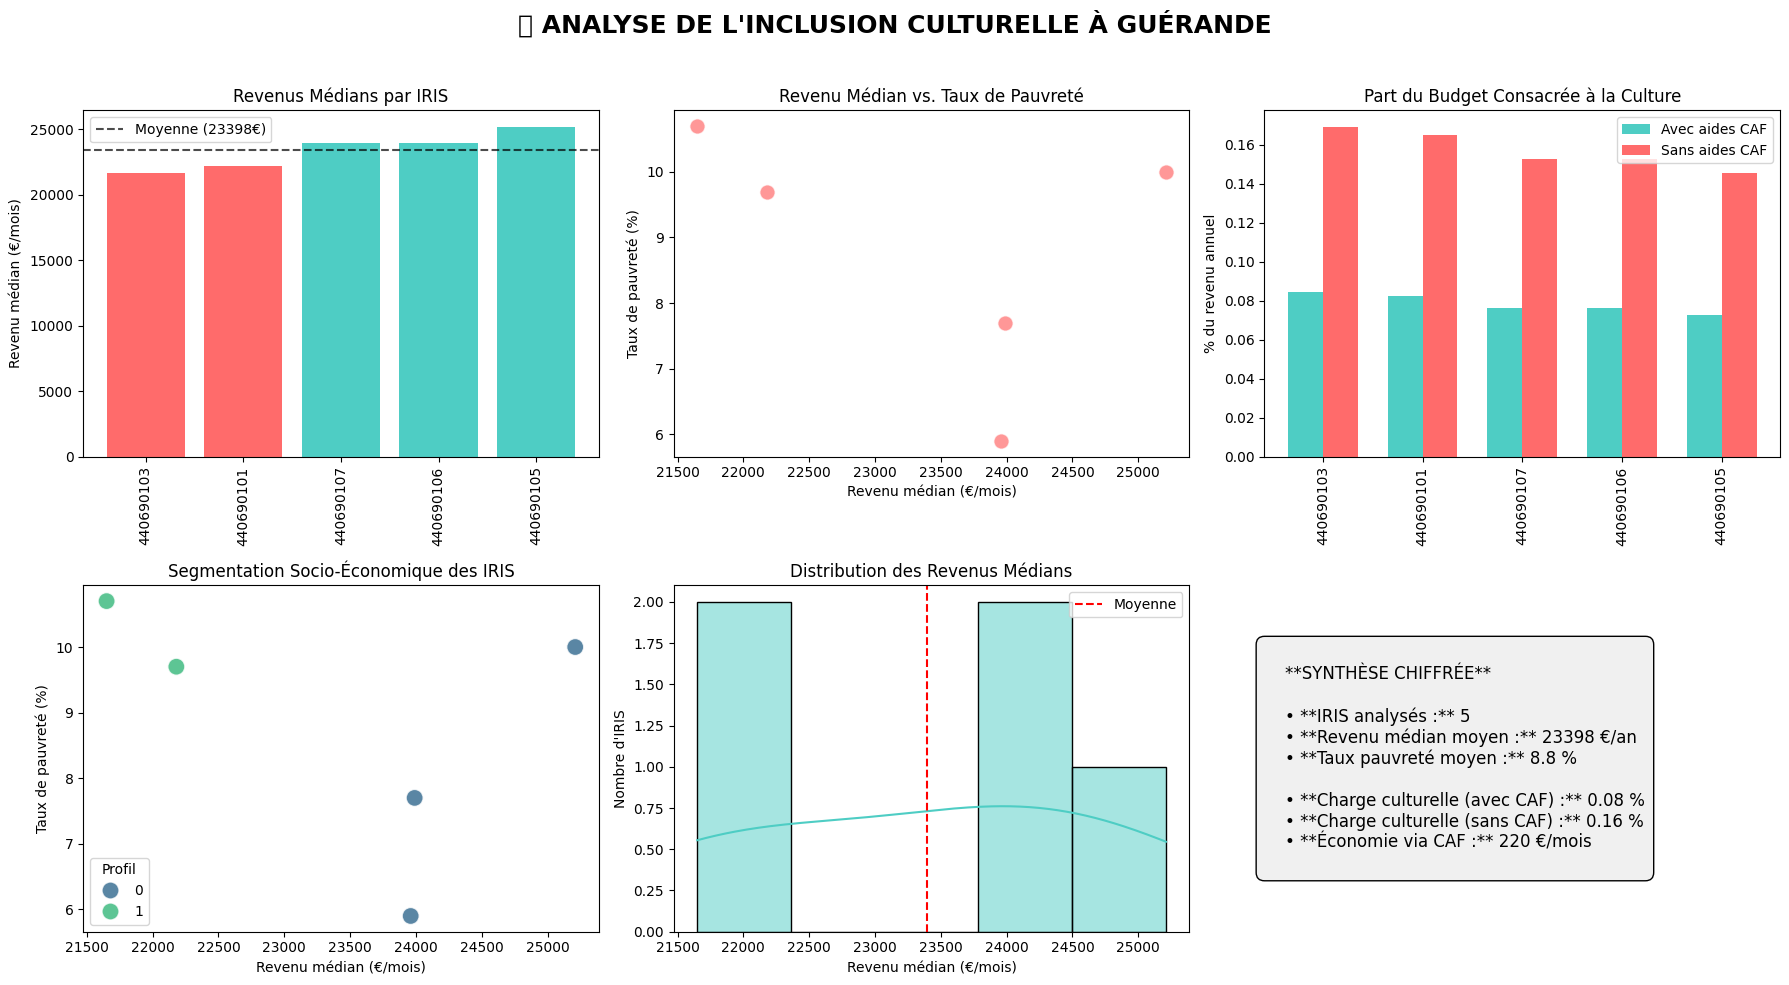

In [53]:
# Génération et affichage de la figure contenant tous les graphiques
fig = create_visualizations(df_analyzed)

# Sauvegarde de la figure en haute résolution
output_filename = 'guerande_analysis_dashboard.png'
fig.savefig(output_filename, dpi=300, bbox_inches='tight')

print(f"✅ Graphiques sauvegardés dans le fichier '{output_filename}'")

# Afficher les graphiques dans le notebook
plt.show()

#Recommandations Budgétaires
Basé sur une estimation de la population et des familles potentiellement ciblées par une aide culturelle renforcée (ex: Pass Culture Solidaire).

- Population estimée (sur la base des IRIS) : ~2500 habitants/IRIS * 5 IRIS = ~12,500 habitants (proche de la réalité).
- Hypothèse : Cibler 25% des familles des quartiers les plus fragiles.
- Suggestion : Un "Pass Culture Solidaire" d'une valeur de 200€ par an par famille ciblée.


In [55]:
# Calculs pour les recommandations
population_estimee_iris = len(df_analyzed) * 2500  # Estimation grossière de la population des IRIS
familles_estimees = population_estimee_iris / 2.3  # Taille moyenne d'un ménage
familles_cibles = familles_estimees * 0.25         # On cible 25% des familles
cout_total_pass = familles_cibles * 200            # Coût d'un pass de 200€
population_reelle_guerande = 16000                 # Population INSEE Guérande
cout_par_habitant = cout_total_pass / population_reelle_guerande

print(f"Population estimée dans les IRIS analysés : {population_estimee_iris:,.0f} habitants")
print(f"Nombre de familles à cibler (hypothèse de 25%) : {familles_cibles:.0f}")
print(f"Budget estimé pour un 'Pass Culture Solidaire' : {cout_total_pass:,.0f} €/an")
print(f"Cela représenterait un coût par habitant pour la ville de : {cout_par_habitant:.2f} €/an")

Population estimée dans les IRIS analysés : 12,500 habitants
Nombre de familles à cibler (hypothèse de 25%) : 1359
Budget estimé pour un 'Pass Culture Solidaire' : 271,739 €/an
Cela représenterait un coût par habitant pour la ville de : 16.98 €/an
